In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# تنظیم مسیرها
IMAGE_DIR = r"C:\Users\omid\Downloads\images\images"
MASK_DIR = r"C:\Users\omid\Downloads\annotations\annotations\trimaps"
TRAIN_LIST = r"C:\Users\omid\Downloads\annotations\annotations\trainval.txt"
IMAGE_SIZE = (128, 128) 


In [3]:
# خواندن نام تصاویر آموزش
with open(TRAIN_LIST) as f:
    image_names = [line.strip().split()[0] for line in f.readlines()]


In [4]:
# آماده‌سازی داده‌ها
def load_image_mask(name):
    image = cv2.imread(os.path.join(IMAGE_DIR, name + ".jpg"))
    image = cv2.resize(image, IMAGE_SIZE)
    image = image / 255.0  # نرمال‌سازی

    mask = cv2.imread(os.path.join(MASK_DIR, name + ".png"), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)

    # تبدیل لیبل‌ها به 0،1،2
    mask = np.where(mask == 1, 0, np.where(mask == 2, 1, 2))
    return image, mask


In [5]:
images = []
masks = []

for name in image_names:
    try:
        img, msk = load_image_mask(name)
        images.append(img)
        masks.append(msk)
    except:
        continue

images = np.array(images)
masks = np.array(masks)
masks = tf.keras.utils.to_categorical(masks, num_classes=3)


In [6]:
# تقسیم به train و val
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.3, random_state=42)


In [7]:
def build_model_scratch():
    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(3, 1, activation='softmax')(x)
    return tf.keras.Model(inputs, x)


In [ ]:
def build_model_transfer():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
    base.trainable = False  # freeze

    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = base(inputs, training=False)  

    x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)  # 8x8
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)  # 16x16
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)  # 32x32
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)  # 64x64
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)  # 128x128

    outputs = tf.keras.layers.Conv2D(3, 1, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)


In [ ]:
#  تابع Augmentation
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
#   کامپایل و آموزش مدل اول
def train_model(model, name):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10
    )
    return history  

In [ ]:
#  کامپایل و آموزش مدل دوم
def train_model_transfer(model, name):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        data_gen.flow(x_train, y_train, batch_size=16),
        validation_data=(x_val, y_val),
        epochs=10
    )
    return history  


In [ ]:
#  مدل اول: Scratch
model_scratch = build_model_scratch()
hist_scratch = train_model(model_scratch, "scratch_model")



Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 370ms/step - accuracy: 0.5331 - loss: 0.9813 - val_accuracy: 0.5920 - val_loss: 0.8924
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 309ms/step - accuracy: 0.5805 - loss: 0.8872 - val_accuracy: 0.5917 - val_loss: 0.8375
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 306ms/step - accuracy: 0.5957 - loss: 0.8375 - val_accuracy: 0.6358 - val_loss: 0.7969
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 306ms/step - accuracy: 0.6316 - loss: 0.7956 - val_accuracy: 0.6487 - val_loss: 0.7671
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 326ms/step - accuracy: 0.6422 - loss: 0.7813 - val_accuracy: 0.6598 - val_loss: 0.7623
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 318ms/step - accuracy: 0.6542 - loss: 0.7687 - val_accuracy: 0.6630 - val_loss: 0.7549
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 0.6583 - loss: 0.7600 - val_accuracy: 0.6643 - val_loss: 0.7497
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 317ms/step - accuracy: 0.6602 - loss: 0.7546 - val_accu

In [13]:
#  مدل دوم: Transfer Learning
model_transfer = build_model_transfer()
hist_transfer = train_model_transfer(model_transfer, "transfer_model")


Epoch 1/10


C:\Users\omid\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 92s 519ms/step - accuracy: 0.6611 - loss: 1.4633 - val_accuracy: 0.7592 - val_loss: 0.6373
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 85s 525ms/step - accuracy: 0.7507 - loss: 0.6415 - val_accuracy: 0.7641 - val_loss: 0.6090
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 85s 525ms/step - accuracy: 0.7596 - loss: 0.6150 - val_accuracy: 0.7601 - val_loss: 0.6191
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 84s 520ms/step - accuracy: 0.7638 - loss: 0.6016 - val_accuracy: 0.7600 - val_loss: 0.6208
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 510ms/step - accuracy: 0.7635 - loss: 0.6005 - val_accuracy: 0.7645 - val_loss: 0.6036
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 84s 519ms/step - accuracy: 0.7675 - loss: 0.5867 - val_accuracy: 0.7631 - val_loss: 0.6050
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 515ms/step - accuracy: 0.7738 - loss: 0.5743 - val_accuracy: 0.7606 - val_loss: 0.6091
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 507ms/step - accuracy: 0.7754 - loss: 0.5671 - val

In [18]:
y_val_pred_scratch = model_scratch.predict(x_val)
y_val_pred_transfer = model_transfer.predict(x_val)


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step


In [19]:
loss_scratch, acc_scratch = model_scratch.evaluate(x_val, y_val)
loss_transfer, acc_transfer = model_transfer.evaluate(x_val, y_val)

print("⚙️ Scratch Model Validation Accuracy:", acc_scratch)
print("🚀 Transfer Model Validation Accuracy:", acc_transfer)


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.6794 - loss: 0.7328
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 676ms/step - accuracy: 0.7623 - loss: 0.6177
⚙️ Scratch Model Validation Accuracy: 0.676798403263092
🚀 Transfer Model Validation Accuracy: 0.7637898921966553


In [14]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # دقت
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # خطا
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



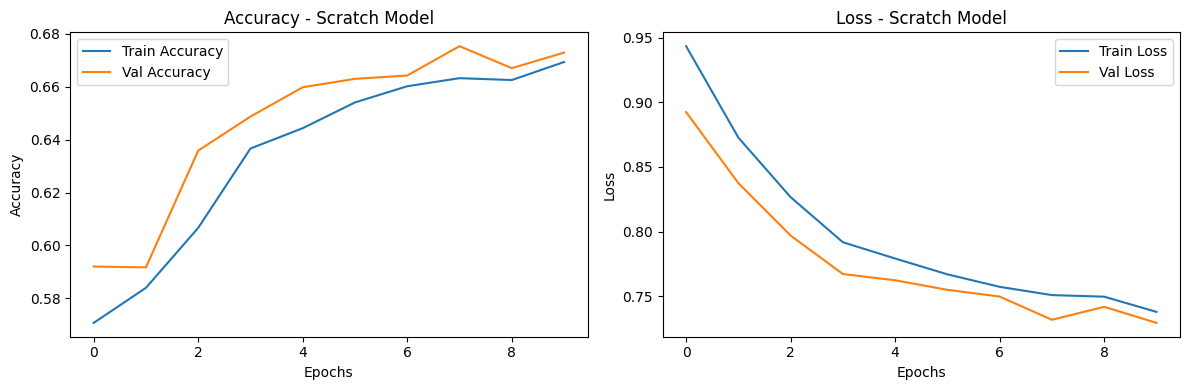

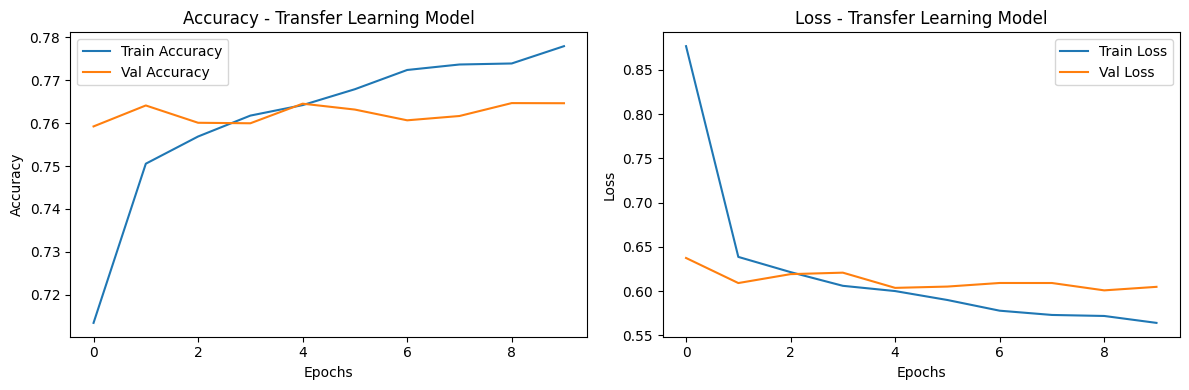

In [15]:
# نمایش نمودار برای هر مدل
plot_history(hist_scratch, "Scratch Model")
plot_history(hist_transfer, "Transfer Learning Model")


In [16]:
def visualize_predictions(model, x_data, y_data, num_samples=5):
    preds = model.predict(x_data)
    preds = np.argmax(preds, axis=-1)
    true_masks = np.argmax(y_data, axis=-1)

    plt.figure(figsize=(15, num_samples * 3))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(x_data[i])
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_masks[i])
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(preds[i])
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 595ms/step


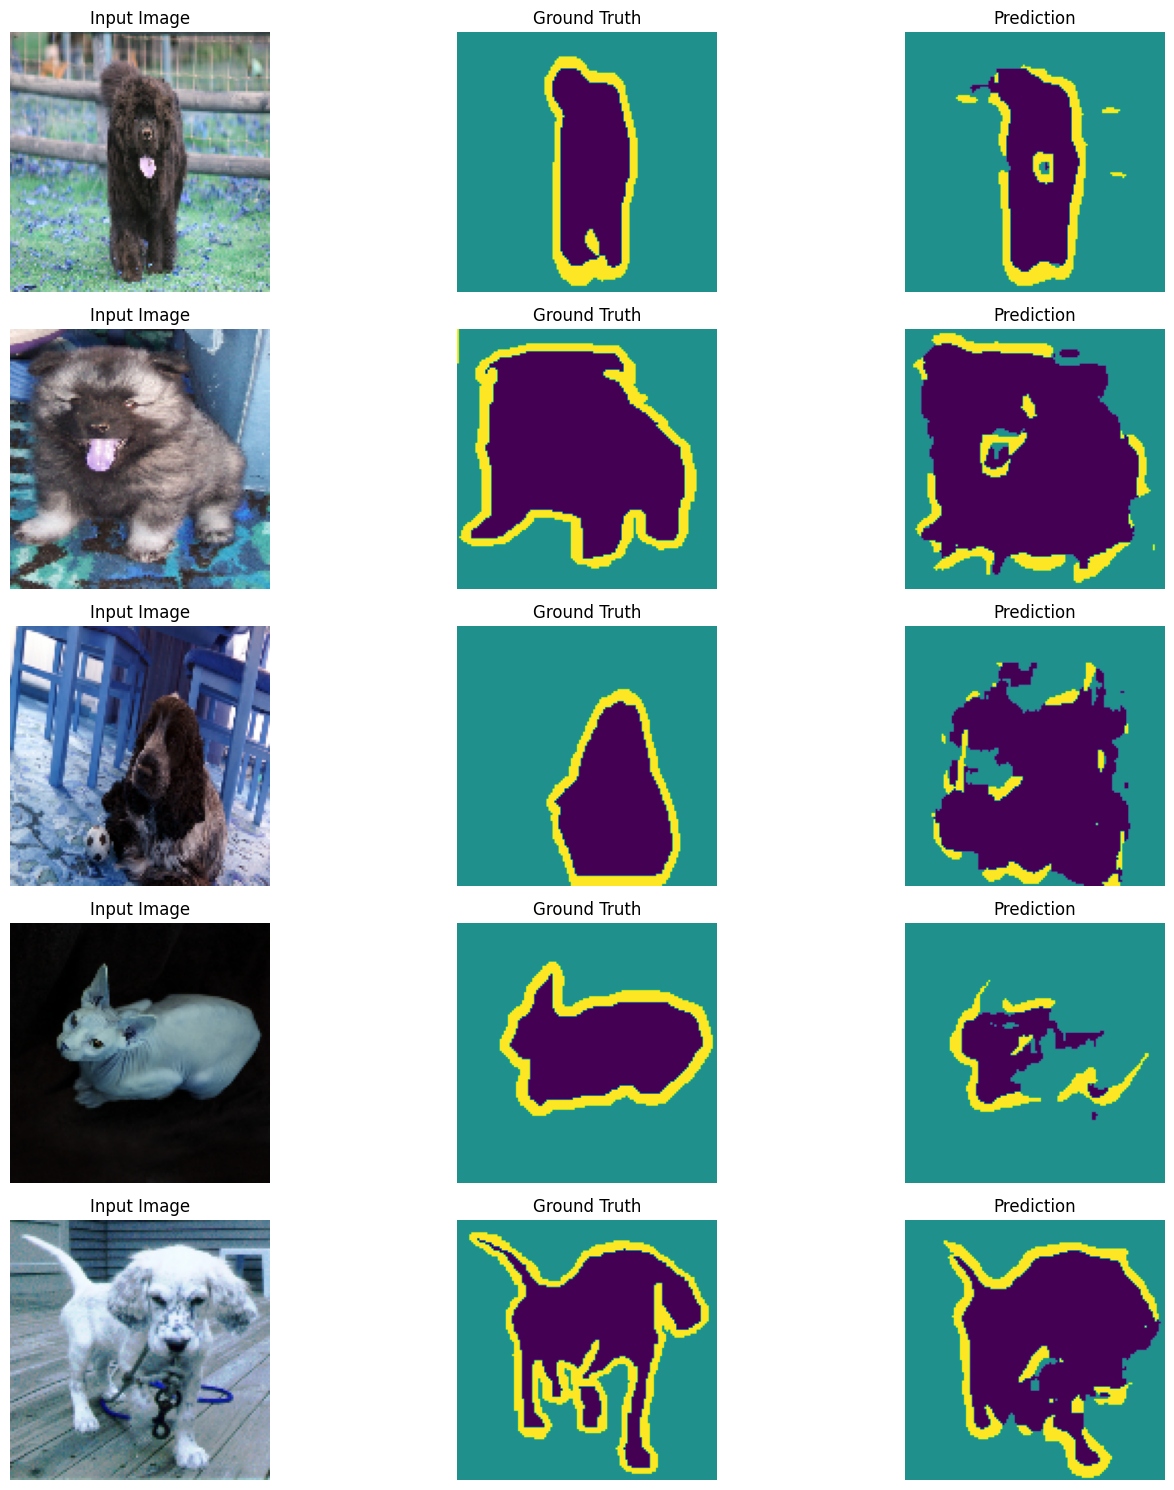

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 538ms/step


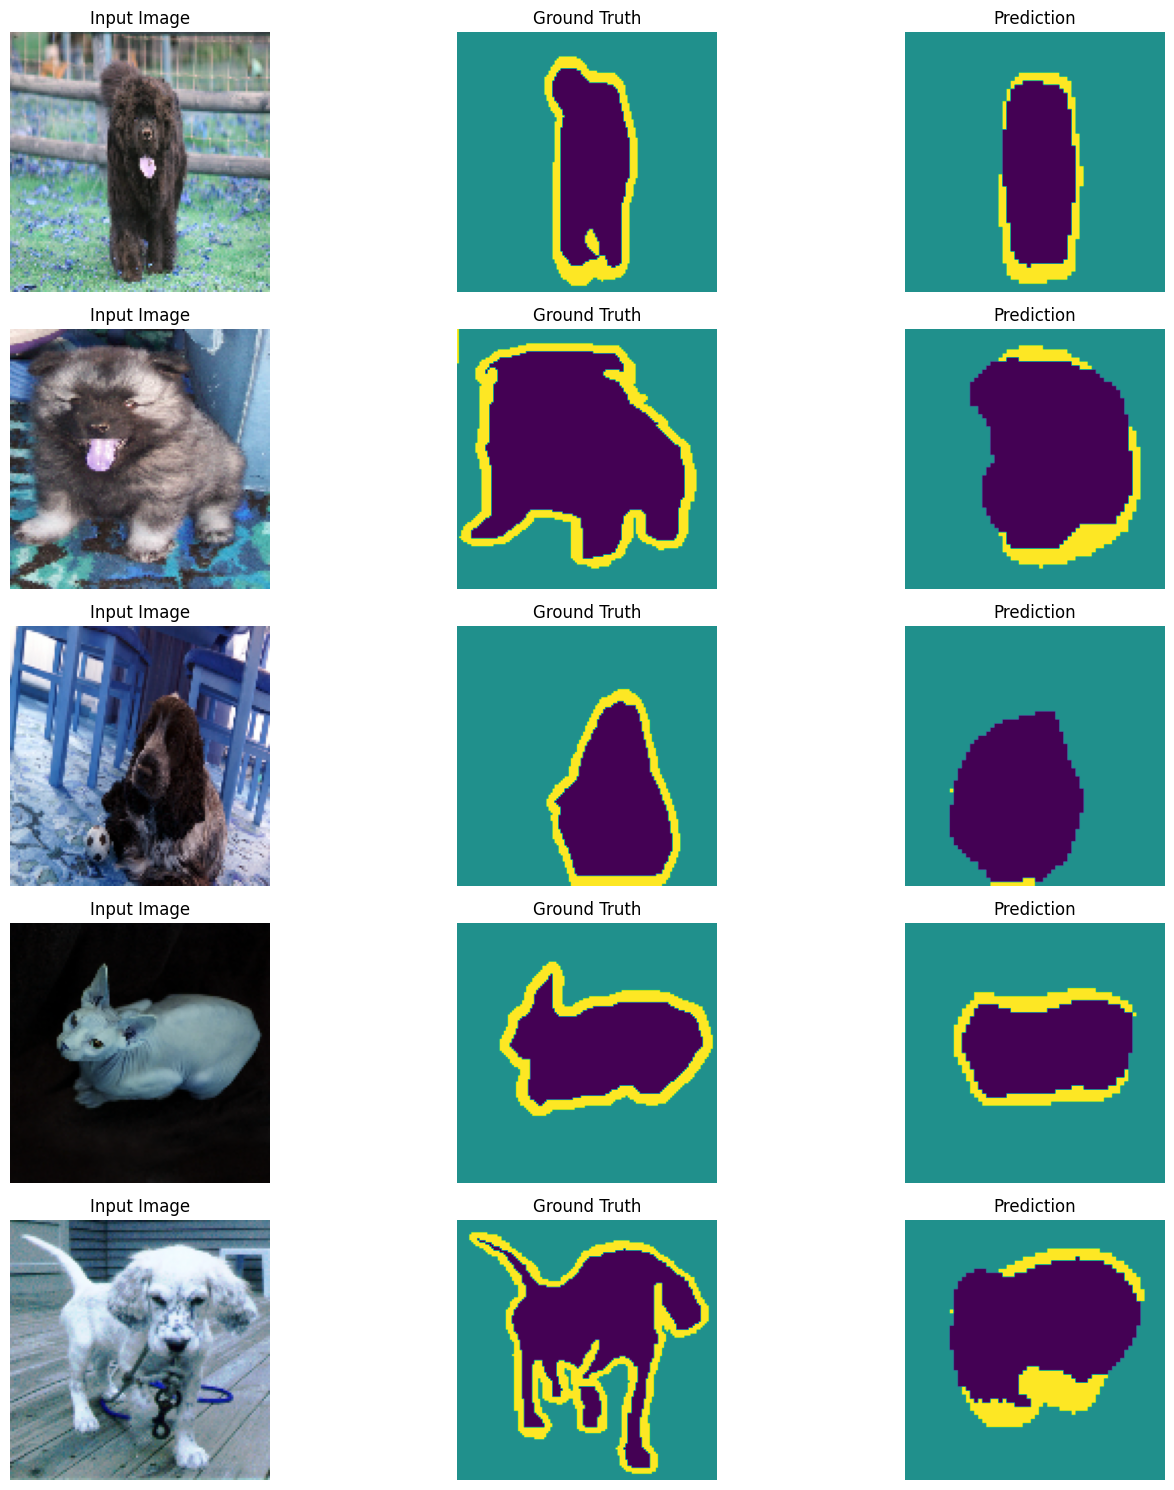

In [17]:
# نمایش نمونه‌هایی از عملکرد مدل Scratch
visualize_predictions(model_scratch, x_val, y_val)

# نمایش نمونه‌هایی از عملکرد مدل Transfer
visualize_predictions(model_transfer, x_val, y_val)
